<a href="https://colab.research.google.com/github/RodrigoZonzin/pousoAlegre_LULC/blob/main/python/selper_PousoAlegre_MUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.3 MB/s eta 0:00:00


In [4]:
import rasterio as rio
from rasterio.plot import show
import numpy as np
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
#from matplotlib_scalebar.scalebar import ScaleBar
from rasterio.plot import plotting_extent

import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
values_list = [0, 1, 2, 3, 4, 5]
colors_list = ['white','#006400', '#aa0000', '#FFFFB2', '#0000FF', '#e993fa']
cmap = ListedColormap(colors_list, name='custom_cmap', N=len(colors_list))

In [16]:
with rio.open('/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_1993PORFAVOR.tif') as src:
    img1993 = src.read()
    raster_meta1993 = src.meta

with rio.open('/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2004PORFAVOR.tif') as src:
    img2004 = src.read()
    raster_meta2004 = src.meta

with rio.open('/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2014NovoBom.tif') as src:
    img2014 = src.read()
    raster_meta2014 = src.meta

with rio.open('/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2024.tif') as src:
    img2024 = src.read()
    raster_meta2024 = src.meta

In [19]:
img1993_path = '/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_1993PORFAVOR.tif'
img2004_path = '/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2004PORFAVOR.tif'
img2014_path = '/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2014NovoBom.tif'
img2024_path = '/content/drive/MyDrive/selper_pousoAlegre/LULC_pousoAlegre_2024.tif'

In [13]:
# Read the shapefile
MUP = gpd.read_file('/content/drive/MyDrive/selper_pousoAlegre/MUP_pousoAlegre/pousoAlegreMUP.shp')

In [29]:
def clip_image(image_path, MUP):
    with rio.open(image_path) as src:
        raster_meta = src.meta
        MUP = MUP.to_crs(raster_meta['crs'])
        shapes = [feature["geometry"] for feature in MUP.__geo_interface__['features']]

        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = raster_meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    return out_image


In [33]:
imgs = []
for img_path in [img1993_path, img2004_path, img2014_path, img2024_path]:
  imgs.append(clip_image(img_path, MUP))

In [35]:
def plotSideBySide(num_x, num_y, imagens, title):
    fig, axs = plt.subplots(num_x, num_y, figsize = (10,10))

    for i, ax in enumerate(axs.flat):
                ax.imshow(np.squeeze(imagens[i]), cmap = cmap)
                ax.set_title(title[i])
                ax.axis('off')

    plt.tight_layout()
    plt.show()

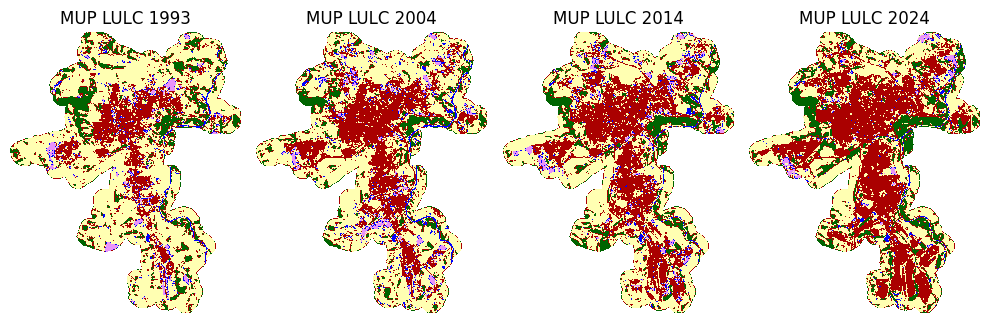

In [36]:
plotSideBySide(1, 4, imgs, ['MUP LULC 1993', 'MUP LULC 2004', 'MUP LULC 2014', 'MUP LULC 2024'])

In [37]:
def calcArea(img):
  img = img[0]
  forest_area = 0
  urban_area = 0
  pasture_area = 0
  water_area = 0
  soil_area = 0

  #30m x 30m = 0,003 km * 0,003 km
  pixel_area = (30/1000)**2

  for linha in img:
    for elemento in linha:
      if elemento == 1:
        forest_area += pixel_area

      elif elemento == 2:
        urban_area += pixel_area

      elif elemento == 3:
        pasture_area += pixel_area

      elif elemento == 4:
        water_area += pixel_area

      elif elemento == 5:
        soil_area += pixel_area

  return ({'forest': forest_area, 'urban': urban_area, 'pasture': pasture_area, 'water': water_area, 'soil': soil_area})


In [38]:
dados = pd.DataFrame(columns = ['img1993', 'img2004'])

In [39]:
dados['img1993'] = calcArea(imgs[0])
dados['img2004'] = calcArea(imgs[1])
dados['img2014'] = calcArea(imgs[2])
dados['img2024'] = calcArea(imgs[3])

In [43]:
dadosDiferenca = pd.DataFrame()
dadosDiferenca['2024vs1993'] = dados['img2024'] - dados['img1993']
dadosDiferenca['2024vs1993pp'] = ((dados['img2024']/dados['img1993'])-1)*100

In [44]:
dadosDiferenca['2004vs1993'] = dados['img2004'] - dados['img1993']
dadosDiferenca['2004vs1993pp'] = ((dados['img2004']/dados['img1993'])-1)*100

In [45]:
dadosDiferenca['2014vs2004'] = dados['img2014'] - dados['img2004']
dadosDiferenca['2014vs2004pp'] = ((dados['img2014']/dados['img2004'])-1)*100

In [46]:
dadosDiferenca['2024vs2014'] = dados['img2024'] - dados['img2014']
dadosDiferenca['2024vs2014pp'] = ((dados['img2024']/dados['img2014'])-1)*100

In [47]:
dadosDiferenca

,2024vs1993,2024vs1993pp,2004vs1993,2004vs1993pp,2014vs2004,2014vs2004pp,2024vs2014,2024vs2014pp
forest,1.2852,15.406193,-1.9557,-23.443737,0.9045,14.162909,2.3364,32.045426
urban,11.6496,129.427057,6.2388,69.313069,2.0331,13.340814,3.3777,19.555023
pasture,-12.6036,-35.708093,-5.2938,-14.998215,-2.4228,-8.075354,-4.8870,-17.719619
water,0.5301,56.743738,0.5589,59.826590,-0.3042,-20.373719,0.2754,23.164269
soil,-0.8613,-40.932421,0.4509,21.428571,-0.2097,-8.207115,-1.1025,-47.006907
